In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login
import pandas as pd 
import numpy as np

notebook_login()

class Config:
    csv_file = "Symptom2Disease.csv"
    

In [2]:
data = pd.read_csv(Config.csv_file, index_col=0)
data = data.reset_index(drop=True)
labels = sorted({x for x in data.label})
dict_ = {}
for i, label in enumerate(labels):
    dict_[label] = i
data['label'] = data['label'].map(dict_)
data.head(5)

,label,text
0,15,I have been experiencing a skin rash on my arm...
1,15,"My skin has been peeling, especially on my kne..."
2,15,I have been experiencing joint pain in my fing...
3,15,"There is a silver like dusting on my skin, esp..."
4,15,"My nails have small dents or pits in them, and..."


In [3]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
import torch 

with torch.no_grad():
    featurized_x = []
    for i, (y, x) in enumerate(data.values):
        ids = tokenizer.encode(x)
        tensor = torch.tensor(ids).to(model.device)
        features = model.get_input_embeddings()(tensor)  # (n_tokens, model_dim)
        featurized_x.append(features.float().mean(0).cpu().detach().numpy())
# concatenate sentence embeddings
# x[None]由于mean(0)返回的array是1维的，x[None]添加一个行维度，合并的时候按照axis=0合并
X = np.concatenate([x[None] for x in featurized_x], axis=0)  # (n_points, model_dim)


In [5]:
X.shape

(1200, 4096)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\hoover\miniforge3\envs\stitch_models\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\hoover\miniforge3\envs\stitch_models\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\hoover\miniforge3\envs\stitch_models\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\hoover\miniforge3\envs\stitch_models\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 24: invalid start byte
c:\Users\hoover\miniforge3\envs\stitch_models\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object ha

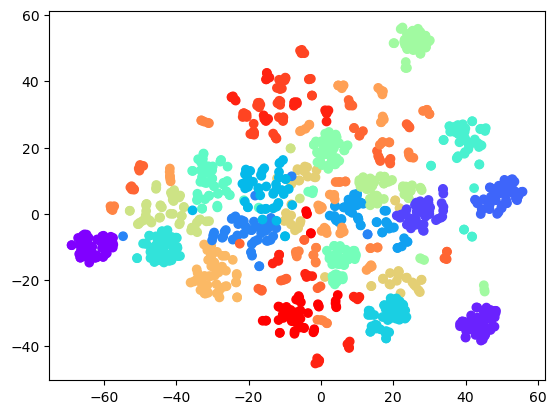

In [6]:
import sklearn
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow

# This is a sanity check that our data clusters nicely
# map our feature space to 2D, plot it and color it by its labels

# integer class for each datapoint
data_class = list(data['label'])

reduced = sklearn.manifold.TSNE(n_components=2, random_state=0).fit_transform(X)
plt.scatter(reduced[:, 0], reduced[:, 1], c=data_class, cmap='rainbow')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



x_train,x_test, y_train, y_test = train_test_split(X, data_class, train_size=0.8, shuffle=True, random_state=10)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [8]:
from sklearn.linear_model import LogisticRegression

# For a real problem, C should be properly cross validated and the confusion matrix analyzed
clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(x_train, y_train)  # 98.33%

# you can also try the sag algorithm:
# clf = LogisticRegression(random_state=0, C=1.0, max_iter=1000, solver='sag').fit(train_x, train_y)

print(f"Precision: {100*np.mean(clf.predict(x_test) == y_test):.2f}%")

Precision: 98.33%


In [20]:
from sklearn.tree import DecisionTreeClassifier


params = {
    'criterion': 'entropy',
    'max_depth': 100,
    'min_samples_split': 3,
    'min_samples_leaf': 5,
    'max_leaf_nodes': 400,
    'random_state': 10,
    'class_weight': None,
}
clf = DecisionTreeClassifier().fit(x_train, y_train)

print(f"Precision: {100*np.mean(clf.predict(x_test) == y_test):.2f}%")

Precision: 50.42%


In [21]:
from sklearn.svm import SVC


clf = SVC().fit(x_train, y_train)
print(f"Precision: {100*np.mean(clf.predict(x_test) == y_test):.2f}%")

Precision: 96.67%
